## Libraries:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from shapely.geometry import Point

## Data preparation
The analysis begins with a dataset containing Chipotle store locations across the USA, complete with latitude and longitude coordinates. Since the data is already complete and free of missing values, no imputation is necessary. To ensure accurate geospatial clustering, the dataset is carefully examined and preprocessed before applying clustering techniques.



In [3]:
df = pd.read_csv('data/chipotle_stores.csv')
df.head()

,state,location,address,latitude,longitude
0,Alabama,Auburn,"346 W Magnolia Ave Auburn, AL 36832 US",32.606813,-85.487328
1,Alabama,Birmingham,"300 20th St S Birmingham, AL 35233 US",33.509721,-86.802756
2,Alabama,Birmingham,"3220 Morrow Rd Birmingham, AL 35235 US",33.595581,-86.647437
3,Alabama,Birmingham,"4719 Highway 280 Birmingham, AL 35242 US",33.422582,-86.698279
4,Alabama,Cullman,"1821 Cherokee Ave SW Cullman, AL 35055 US",34.154134,-86.841220


In [4]:
df.isnull().sum()

state        0
location     0
address      0
latitude     0
longitude    0
dtype: int64

## Visualization of Chipotle Locations

Visualizing the raw data first helps confirm the dataset’s geographic coverage and identify patterns like concentration in certain regions.



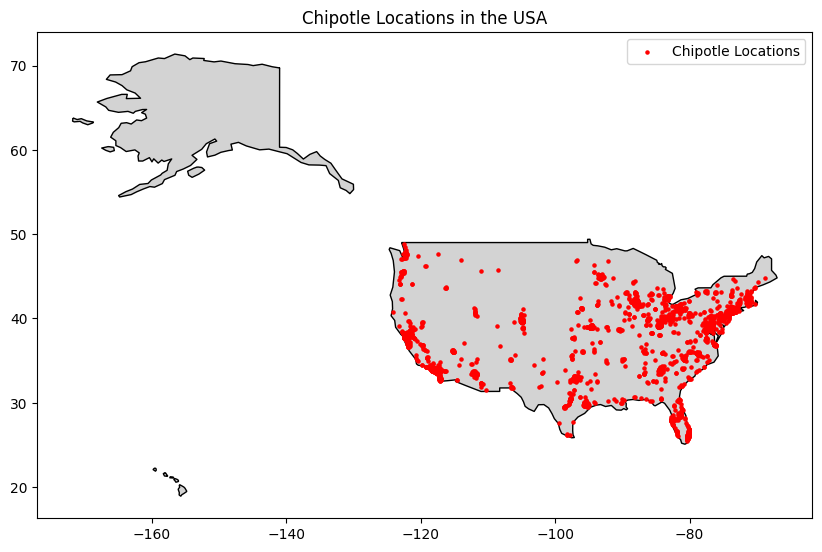

In [5]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
usa = gpd.read_file('data/geodata/ne_110m_admin_0_countries.shp')
usa = usa[usa['ADMIN'] == 'United States of America']

fig, ax = plt.subplots(figsize=(10, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=5, label='Chipotle Locations')
plt.title('Chipotle Locations in the USA')
plt.legend()
plt.show()

## Elbow Method to Determine Optimal Number of Clusters

The goal is to minimize inertia without overfitting by adding unnecessary clusters. The Elbow Method helps to determine the optimal number of clusters because it balances cluster tightness (low inertia) with simplicity (fewer clusters). The plot shows a noticeable bend around k=10, suggesting that beyond this, additional clusters don’t significantly improve the grouping.





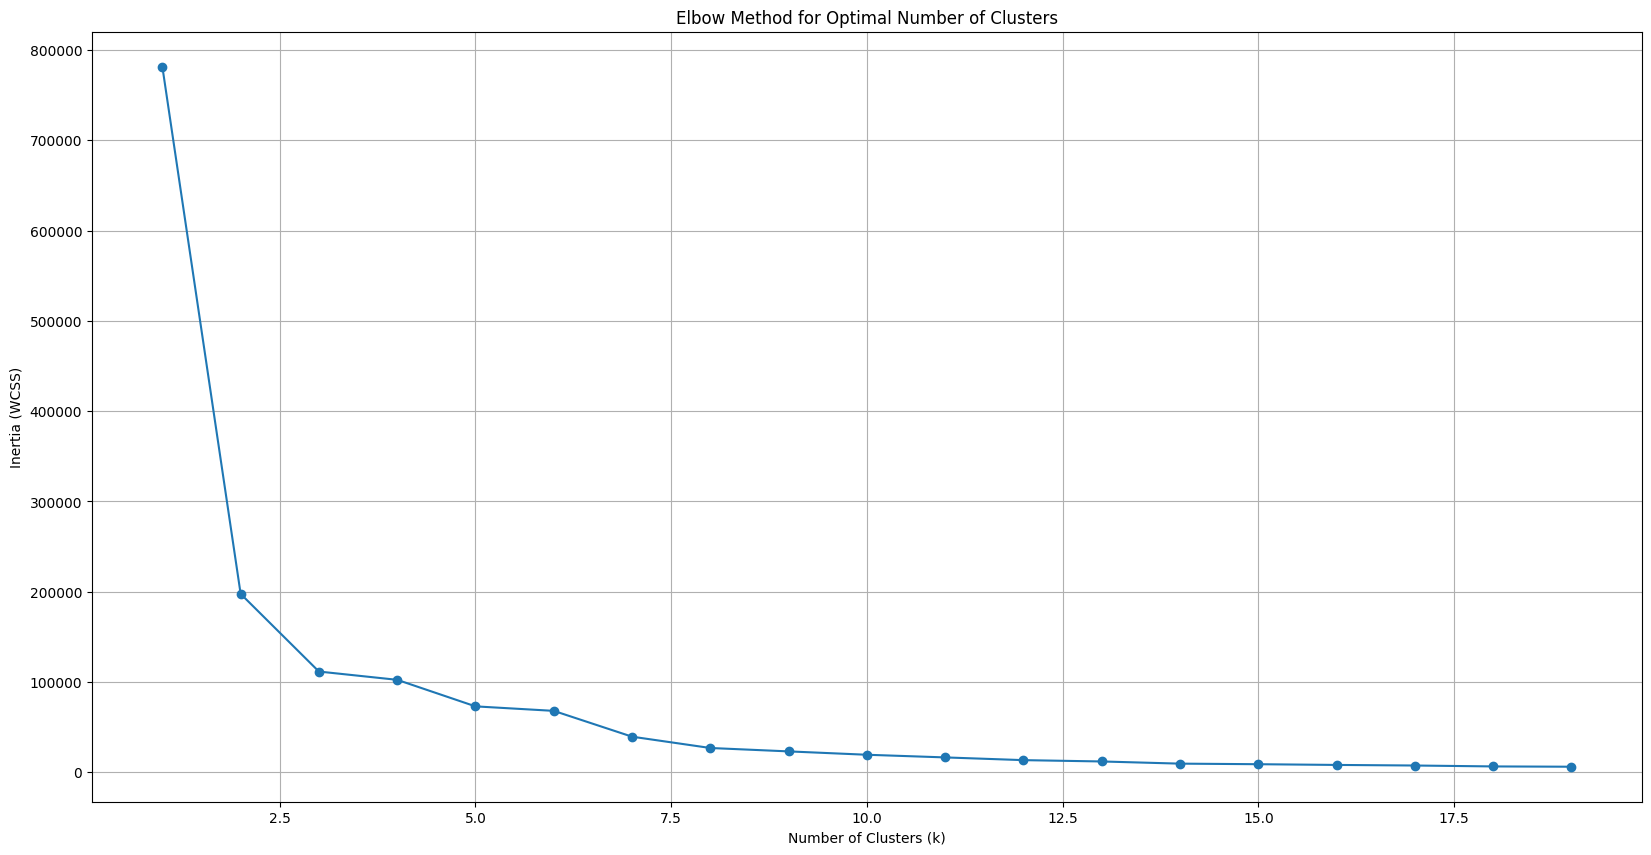

In [6]:
X = df[['latitude', 'longitude']].values
inertias = []
k_range = range(1, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

## Clustering Algorithms Comparison 

By comparing this four algorithms ensures the selection of the best one for Chipotle’s geographic distribution

#### Why these methods?

 This four methods handles geographic data differently:

 - K-means: assumes spherical clusters and requires a predefined k. It’s fast, scalable, and works well for evenly distributed data like store locations in populated areas.

 - DBSCAN: doesn’t require specifying k and can identify noise (outliers), which is useful for sparse rural Chipotle locations that don’t fit into dense urban clusters. Also, converting to a UTM projection (meters) ensures accurate distance calculations. 
 Besides it was add parameter tuning, because DBSCAN’s performance depends heavily on eps (max distance for points in a cluster) and min_samples (minimum points per cluster). Testing multiple pairs finds the best fit for the data’s scale.
 
 - Agglomerative: this hierarchical method builds clusters bottom-up, merging points based on proximity (Ward’s linkage minimizes variance). It’s good for nested or unevenly sized clusters. It complements K-means by not assuming spherical clusters, offering a different perspective on the data.

 - GMM: assumes data comes from a mix of Gaussian distributions, allowing for soft clustering (probabilistic assignment) and elliptical shapes. It’s more flexible than K-means, potentially capturing overlapping clusters

#### The Silhouette Score:

  The Silhouette Score helped objectively select the best method—here, the one with the highest score—ensuring the clusters are meaningful and well-separated. It measures how similar points are to their own cluster vs. others (range: -1 to 1). Higher scores mean better-defined clusters.


In [7]:
optimal_k = 10
clustering_results = {}

# K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_labels)
clustering_results['K-means'] = {'labels': kmeans_labels, 'score': kmeans_silhouette}
print(f"K-means Silhouette Score: {kmeans_silhouette:.3f}")

# DBSCAN
gdf_utm = gdf.to_crs(epsg=32610) 
X_km = np.array([[point.x, point.y] for point in gdf_utm.geometry]) / 1000
best_silhouette = -1  
best_labels = None
best_eps = None
best_min_samples = None

for eps_km, min_samples in [(15, 5), (25, 5), (50, 5), (100, 10)]:  
    dbscan = DBSCAN(eps=eps_km, min_samples=min_samples, metric='euclidean') 
    dbscan_labels = dbscan.fit_predict(X_km)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  

    if n_clusters > 1:
        dbscan_silhouette = silhouette_score(X_km, dbscan_labels)
        print(f"DBSCAN (eps={eps_km} km, min_samples={min_samples}): {dbscan_silhouette:.3f}, Clusters: {n_clusters}")
        if dbscan_silhouette > best_silhouette:
            best_silhouette = dbscan_silhouette
            best_labels = dbscan_labels
            best_eps = eps_km
            best_min_samples = min_samples
    else:
        print(f"DBSCAN (eps={eps_km} km, min_samples={min_samples}): No clusters or all noise")

if best_silhouette > -1: 
    clustering_results['DBSCAN'] = {'labels': best_labels, 'score': best_silhouette}
    print(f"DBSCAN Silhouette Score: {best_silhouette:.3f} ")

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agglo_labels = agglo.fit_predict(X)
agglo_silhouette = silhouette_score(X, agglo_labels)
clustering_results['Agglomerative'] = {'labels': agglo_labels, 'score': agglo_silhouette}
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.3f}")

# GMM
gmm = GaussianMixture(n_components=10,covariance_type='spherical', random_state=42)
gmm_labels = gmm.fit_predict(X)
gmm_silhouette = silhouette_score(X, gmm_labels)
clustering_results['Gaussian Mixtures'] = {'labels': gmm_labels, 'score': gmm_silhouette}
print(f"Gaussian Mixtures Silhouette Score: {gmm_silhouette:.3f}")

best_method = max(clustering_results, key=lambda x: clustering_results[x]['score'])
best_labels = clustering_results[best_method]['labels']
best_score = clustering_results[best_method]['score']
print(f"\nBest Clustering Method: {best_method} with Silhouette Score: {best_score:.3f}")

K-means Silhouette Score: 0.579
DBSCAN (eps=15 km, min_samples=5): 0.264, Clusters: 61
DBSCAN (eps=25 km, min_samples=5): 0.412, Clusters: 70
DBSCAN (eps=50 km, min_samples=5): 0.522, Clusters: 60
DBSCAN (eps=100 km, min_samples=10): 0.508, Clusters: 24
DBSCAN Silhouette Score: 0.522 
Agglomerative Clustering Silhouette Score: 0.537
Gaussian Mixtures Silhouette Score: 0.548

Best Clustering Method: K-means with Silhouette Score: 0.579


## Cluster Analysis and Centroid Identification

It assigns cluster labels, isolates noise, and calculates centroids to summarize each group. Then identified the densest cluster’s centroid—key for understanding Chipotle’s core geographic focus based on the highest number of locations.

In [8]:
gdf['cluster'] = best_labels
clusters = gdf[gdf['cluster'] != -1]
noise = gdf[gdf['cluster'] == -1]

centroids = clusters.groupby('cluster').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
cluster_sizes = clusters['cluster'].value_counts()
centroids['size'] = centroids['cluster'].map(cluster_sizes)

best_centroid = centroids.loc[centroids['size'].idxmax()]
best_cluster_id = best_centroid['cluster']
print(f"Best Centroid: Lat {best_centroid['latitude']:.3f}, Lon {best_centroid['longitude']:.3f}")
print(f"Cluster Size (Density): {best_centroid['size']}")

Best Centroid: Lat 40.319, Lon -74.960
Cluster Size (Density): 635.0


## Visualization of Clusters and Centroids

It visualized the clusters to confirm their geographic distribution, with noise in grey, clusters in distinct colors, and centroids marked clearly. The best centroid stands out in blue because it represents the densest cluster.



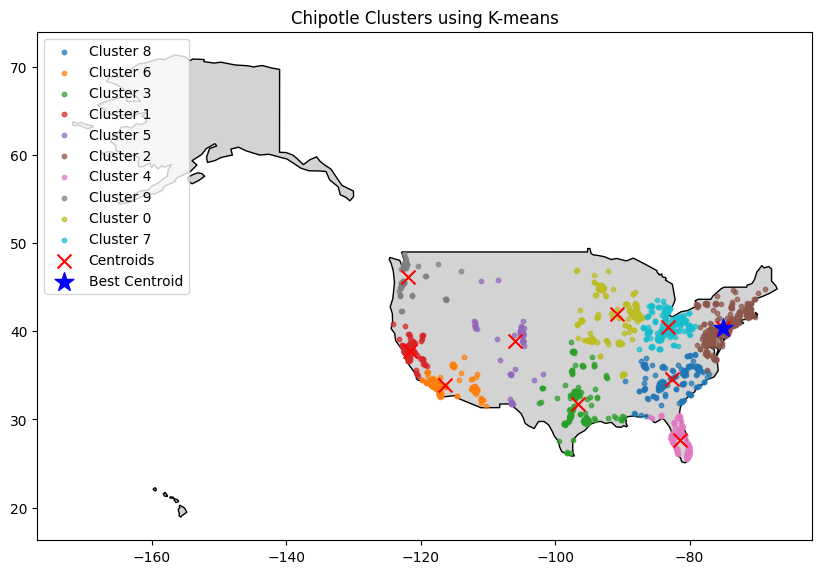


Why This Centroid?
- Highest Density: Cluster 2.0 has 635.0 locations.
- Proximity: Central to 635.0 Chipotle stores.
- Connectivity: Ideal starting point for a road trip visiting dense Chipotle locations.


In [9]:
centroid_geometry = [Point(xy) for xy in zip(centroids['longitude'], centroids['latitude'])]
centroids_gdf = gpd.GeoDataFrame(centroids, geometry=centroid_geometry, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
if len(noise) > 0:
    noise.plot(ax=ax, color='grey', markersize=5, label='Noise', alpha=0.5)

for cluster_id in clusters['cluster'].unique():
    cluster_data = clusters[clusters['cluster'] == cluster_id]
    cluster_data.plot(ax=ax, markersize=10, label=f'Cluster {cluster_id}', alpha=0.7)

centroids_gdf.plot(ax=ax, color='red', marker='x', markersize=100, label='Centroids')
best_centroid_gdf = centroids_gdf[centroids_gdf['cluster'] == best_cluster_id]
best_centroid_gdf.plot(ax=ax, color='blue', marker='*', markersize=200, label='Best Centroid')

plt.title(f'Chipotle Clusters using {best_method}')
plt.legend()
plt.show()

print("\nWhy This Centroid?")
print(f"- Highest Density: Cluster {best_cluster_id} has {best_centroid['size']} locations.")
print(f"- Proximity: Central to {best_centroid['size']} Chipotle stores.")
print("- Connectivity: Ideal starting point for a road trip visiting dense Chipotle locations.")